In [47]:
from scipy.stats import norm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

The distribution of the population is given by GMM with 2 gaussians

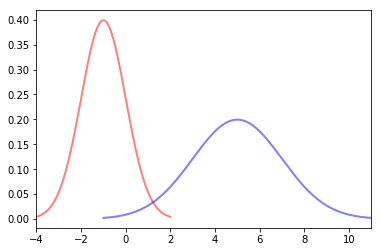

In [48]:
mu1 = -1
sigma1 = 1
x1 = np.linspace(mu1 - 3 * sigma1, mu1 + 3 * sigma1, 1000)
y1 = norm.pdf(x1, mu1, sigma1)

mu2 = 5
sigma2 = 2
x2 = np.linspace(mu2 - 3 * sigma2, mu2 + 3 * sigma2, 1000)
y2 = norm.pdf(x2, mu2, sigma2)

plt.plot(x1, y1, color='red', lw=2, ls='-', alpha=0.5)
plt.plot(x2, y2, color='blue', lw=2, ls='-', alpha=0.5)

plt.xlim(min(mu1 - 3 * sigma1, mu2 - 3 * sigma2), max(mu1 + 3 * sigma1, mu2 + 3 * sigma2))
plt.show()

Our data is a sample of 500 instances from each gaussian

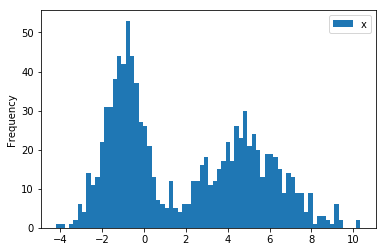

In [49]:
np.random.seed(10)
first_gaussian = norm.rvs(loc=mu1, scale=sigma1, size=500)
second_gaussian = norm.rvs(loc=mu2, scale=sigma2, size=500)
xs = np.concatenate((first_gaussian, second_gaussian))
df = pd.DataFrame(data={'x': xs})
ax = df.plot.hist(bins=70)

Given the sample data we want to run EM in order to find the population distribution. <br>
We first need to decide about the the distribution parameters. <br>
After seeing the sample plot we can assume that the distribution of the population is GMM woth 2 gaussians (remember that we won't see the first plot of the real distribution, but only the sample plot) 

In [50]:
# TODO: init the GaussianMixture with 2 components
from sklearn.mixture import GaussianMixture
EM = GaussianMixture(n_components=2)
# TODO: fit your model with the given data and predict the gaussian for each data point 
# hint: use sklearn.mixture.GaussianMixture ducomentation if you need help with find the relevant method
z = EM.fit(xs.reshape(-1,1)) 
z=z.predict(xs.reshape(-1,1))

df['z'] = z

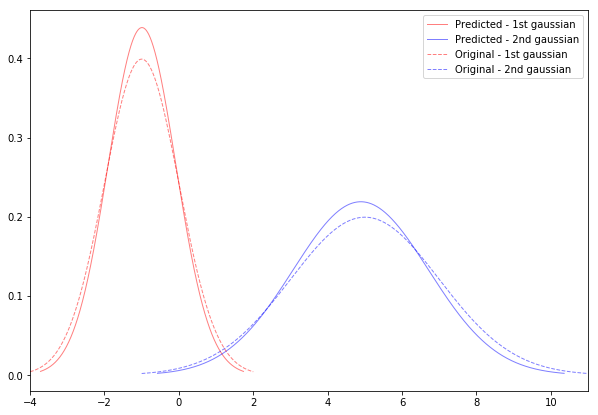

-0.991645233753801 0.9092561066616276 -1 1
4.890644124456295 1.8218749170651534 5 2


In [51]:
# code for ploting the original distribution with the one that we found with the EM
plt.figure(figsize=(10, 7))
mu_hat1 = df['x'][df['z'] == 0].mean()
sigma_hat1 = df['x'][df['z'] == 0].std()
x_hat1 = np.linspace(mu_hat1 - 3 * sigma_hat1, mu_hat1 + 3 * sigma_hat1, 1000)
y_hat1 = norm.pdf(x_hat1, mu_hat1, sigma_hat1)

mu_hat2 = df['x'][df['z'] == 1].mean()
sigma_hat2 = df['x'][df['z'] == 1].std()
x_hat2 = np.linspace(mu_hat2 - 3 * sigma_hat2, mu_hat2 + 3 * sigma_hat2, 1000)
y_hat2 = norm.pdf(x_hat2, mu_hat2, sigma_hat2)

plt.plot(x_hat1, y_hat1, color='red', lw=1, ls='-', alpha=0.5)
plt.plot(x_hat2, y_hat2, color='blue', lw=1, ls='-', alpha=0.5)

plt.xlim(min(mu_hat1 - 3 * sigma_hat1, mu_hat2 - 3 * sigma_hat2), 
         max(mu_hat1 + 3 * sigma_hat1, mu_hat2 + 3 * sigma_hat2))

mu1 = -1
sigma1 = 1
x1 = np.linspace(mu1 - 3 * sigma1, mu1 + 3 * sigma1, 1000)
y1 = norm.pdf(x1, mu1, sigma1)

mu2 = 5
sigma2 = 2
x2 = np.linspace(mu2 - 3 * sigma2, mu2 + 3 * sigma2, 1000)
y2 = norm.pdf(x2, mu2, sigma2)

plt.plot(x1, y1, color='red', lw=1, ls='--', alpha=0.5)
plt.plot(x2, y2, color='blue', lw=1, ls='--', alpha=0.5)

plt.xlim(min(mu1 - 3 * sigma1, mu2 - 3 * sigma2), max(mu1 + 3 * sigma1, mu2 + 3 * sigma2))

plt.legend(['Predicted - 1st gaussian', 'Predicted - 2nd gaussian', 
            'Original - 1st gaussian', 'Original - 2nd gaussian'])

plt.show()


print(mu_hat1, sigma_hat1, mu1, sigma1)
print(mu_hat2, sigma_hat2, mu2, sigma2)

As we can see, we almost found the original parameter only with 500 samples from each gaussian

### Implementing EM

In this part you will implement the EM algorithm

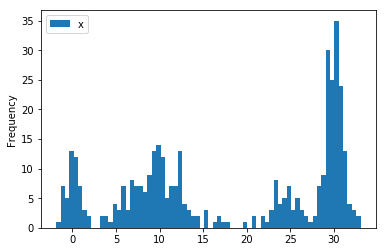

In [52]:
# reading the data
df = pd.read_csv('/Users/marissaposner/Downloads/data.csv')
# TODO: plot the data in order to decide about the parameters of the distribution, use 70 bins
ax = df.plot.hist(bins=70)

In [53]:
# TODO: given the above plot, decide from how many guassian you think the data came from
K = 4

We implemented for you the EM wrraper algorithm.<br>
This function calls to helper functions that you need to implement:<br>
1. init - gussing the initial values of W, Mu, sigma
2. Expectation - perform the E-step
3. Maximization - perform the M-step
4. calc_delta - calculating the diffrence between the old parms to the new params for the stopping condition


#### init

In [54]:
df.head()

,x
0,-0.023116
1,1.596508
2,1.009497
3,1.043274
4,0.294296


In [55]:
def init(data, K):
    """
    :param data: the complete data
    :param K: number of gaussians
    :return the initial guess of W, Mu, sigma
    """
    # TODO: complete the init function
    # Make initial guess
    N = data.shape[0]
    # guess each w as 1/K
    W = [1/float(K)]*K      #want an array of K

    # Guess mu as center of K quantiles, see pandas.qcut documentation
    quat_data, bins = pd.qcut(data['x'],K,retbins='true',labels=False)
    Mu = [0] * K
    for k in range(K):
        Mu[k] = float(bins[k+1]+bins[k])/2

    # Guess sigma as empiric sigma
    sum = [0] * K
    for index, bin in quat_data.iteritems():
        sum[bin] += (data["x"][index]-Mu[bin])**2     #taking difference for how far off the mean it is 
    sigma = [0] * K     #setting up default val=0
    for k in range(K):
        sigma[k] = ((float(K)/N)*sum[k])**0.5      #sqrt of above
    return W, Mu, sigma

In [56]:
quat_data,bins=pd.qcut(df["x"],K,retbins="true",labels=False)
Mu=[0]*K
print(bins)


[-1.86480456  8.70615443 20.31163077 29.72667305 33.06113618]


#### E-step

In [57]:
def Expectation(data, Mu, sigma, W):
    """
    :param data: the complete data
    :param Mu: expectation of each gaussian
    :param sigma: std for of gaussian
    :param W: weight of each gaussian
    :return ranks matrix: r(x,k)- responsibility of each data point x to gaussian k 
            Q: dividend of ranks matrix (likelihood)      output responsibilities
    """
    #K = W.__len__()
    K=len(W)
    rank_df = pd.DataFrame(columns=range(K))
    Q_df = pd.DataFrame(columns=range(K))
   
    for index, row in data.iterrows():
        x = row["x"]
        sum = 0
        # TODO: calculate the value of x in each gaussian multiple by the relevant W
        for j in range(K):
            sum += W[j]*norm.pdf(x,loc=Mu[j],scale=sigma[j])   #probability density function 

        R_x_k = [0] * K   #responsibilities
        Q = [0] * K #initializing array to be zeros
        # TODO: complete the calculation for Q[k] and R_x_k[k]
        # Q[k] is the value of x in the k gaussian multiple by W[k]
        for k in range(K):
            Q[k] = W[k]*norm.pdf(x,loc=Mu[k],scale=sigma[k])
            R_x_k[k] = float(Q[k]) / sum
        rank_df.loc[index] = R_x_k   #put in dataframe
        Q_df.loc[index] = Q
    return rank_df, Q_df

#### M-step

In [58]:
def Maximization(data, K, ranks):
    """
    :param data: the complete data
    :param K: number of gaussians
    :param ranks: ranks matrix- r(x,k)- responsibility of each data point x to gaussian k 
    :return W_new: new weight parameter of each gaussian 
            Mu_new: new expectation parameter of each gaussian 
            sigma_new: new std parameter of each gaussian 
    """
    N = data.shape[0]
    ranks_sum = ranks.sum(axis=0).values 
    W_new = [0] * K
    Mu_new = [0] * K 
    # TODO: complete the calculation for the W_new
    for k in range(K):
        W_new[k] = (1/float(N))*ranks_sum[k] #sum of responsibility for k gaussian 
        #new W =avg of responsibility for k gaussian
        # TODO: complete the calculation for the Mu_new
        sum=0
        for i in range(N):
            sum+=ranks[k][i]*data['x'][i]
        Mu_new[k] = (1/float(ranks_sum[k]))* sum
        #new w=sum of responsibilities/N

    sigma_new = [0] * K
    # TODO: complete the calculation for the sigma_new
    for k in range(K):
        sum=0
        for i in range(N):
            sum+=ranks[k][i]*((data['x'][i]-Mu_new[k])**2)
        sigma_new[k] = ((1/float(ranks_sum[k]))*sum)**0.5

    return W_new, Mu_new, sigma_new

#### calc_delta

In [59]:
def calc_delta(old_param, new_param):
    """
    :param old_param: old parameters to compare
    :param new_param: new parameters to compare
    :return maximum delta between each old and new parameter (max diff btwn params)
    """
    K = len(old_param) 
    max_delta = 0
    # TODO: find the maximal delta between each old and new parameter
    for k in range(K):
        delta=0
        if old_param[k]>0: #wouldnt work if mu was actually 0
            delta=abs(new_param[k]-old_param[k])/abs(old_param[k])
        if delta>max_delta:
            max_delta=delta
    return max_delta

#### Already implemented functions

In [60]:
# helper function for plotting
def plotGMM(K, res, Mu, sigma, data, iter=-1):
    for k in range(K):
        res_bin= res[res == k]
        dots = data["x"][res_bin.index]
        plt.scatter(dots.values, norm.pdf(dots.values, loc=Mu[k], scale=sigma[k]), 
                    label="Mu=%.2f, Sigma=%.2f"%(Mu[k], sigma[k]), s=10)
    plt.ylabel('probability')
    if iter>=0:
        plt.title('Expectation Maximization - GMM - iteration {}'.format(iter))
    else:
        plt.title('Expectation Maximization - GMM')
    plt.legend()
    plt.ylim(0,0.5)
    plt.show()

In [61]:
def ExpectationMaximization(data, K, maxIter, epsilon):
    """
    :param data: the complete data
    :param K: number of gaussians
    :param maxIter: maximal number of iterations to perform
    :param epsilon: minimal change in parameters to declare convergence
    :return gaussian estimation for each point
    """

    W, Mu, sigma = init(data, K)

    # Loop until convergence
    delta = np.infty
    iter = 0
    
    log_likelihood = []
    while delta > epsilon and iter <= maxIter: #stop if meet these conditions
        # E step
        ranks, Q = Expectation(data, Mu, sigma, W)
        
        # ranks form the responsibilities matrix
        likelihood = Q.sum(axis=1)
        log_likelihood.append(np.sum(np.log(likelihood.values), axis = 0))

        # M step
        W_new, Mu_new, sigma_new = Maximization(data, K, ranks)

        # Check significant change in parameters
        delta = max(calc_delta(W, W_new), calc_delta(Mu, Mu_new), calc_delta(sigma, sigma_new))
        W, Mu, sigma = W_new, Mu_new, sigma_new

        if iter%10 == 0:
            res = ranks.idxmax(axis=1)
            plotGMM(K, res, Mu, sigma, data, iter)
        iter += 1

    print()
    plt.show()
    
    res = ranks.idxmax(axis=1)

    # Display estimated Gaussian:
    plotGMM(K, res, Mu, sigma, data, iter)

    # Display log likelihood changes:
    plt.plot(log_likelihood)
    plt.xlabel('iteration')
    plt.ylabel('log likelihood')
    plt.title('Log likelihood over iteration')
    plt.show()
    
    return res, Mu, sigma

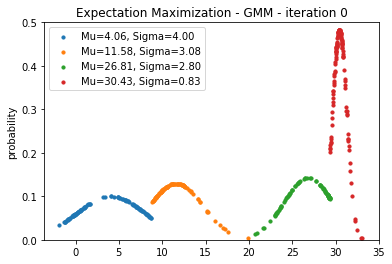

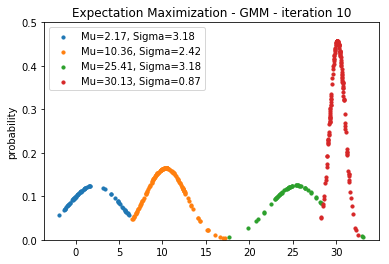

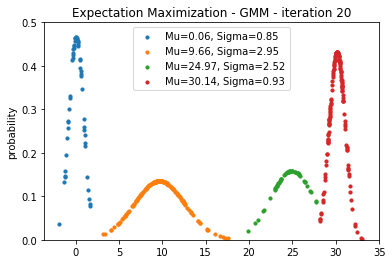

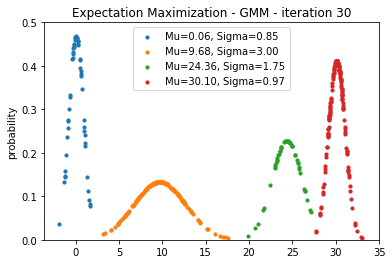

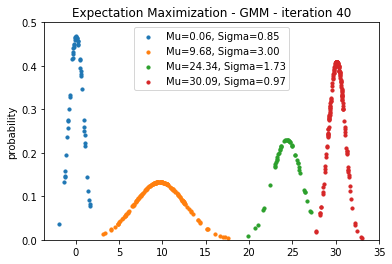

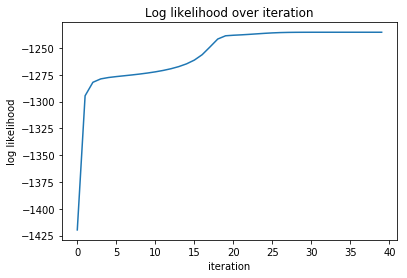

In [62]:
# run the EM algorithm
res, Mu, sigma = ExpectationMaximization(df, K, 1000, 0.0001)

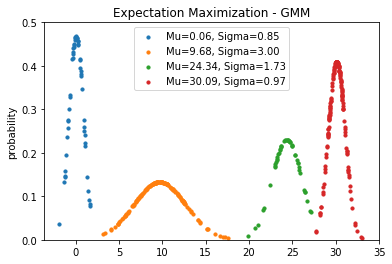

In [63]:
# ploting the output distribution: real data
plotGMM(K, res, Mu, sigma, df)